In [1]:
import os
import glob
import torchmetrics.wrappers
from torchmetrics import MetricTracker
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import torchvision.models as models

from PIL import Image

from classes.NIH_dataset_class import NIH_dataset
from classes.Metrics_class import metrics_collection as metrics, metrics_plot

# Importing the hyperparameters
from hyperparams import *

# Loading the data

In [2]:
# Getting the directories for data
DATA_DIR = os.path.join(os.getcwd(), 'dataset')
IMAGE_DIR = [os.path.join(os.path.join(os.getcwd(), 'dataset'), f'images_{str(i).zfill(3)}', 'images') for i in range(1, 13)]
LABELS_CSV = os.path.join(DATA_DIR, 'Data_Entry_2017.csv')
BBOX_CSV = os.path.join(DATA_DIR, 'BBox_List_2017.csv')

labels = pd.read_csv(LABELS_CSV)
bbox = pd.read_csv(BBOX_CSV)

# Splitting the labels into multiple rows
labels_expanded = labels.copy()
labels_expanded['Finding Label'] = labels_expanded['Finding Labels'].str.split('|')

# Making a unique ID column for each image
labels_expanded['Id'] = list(zip(labels_expanded['Patient ID'], labels_expanded['Follow-up #']))
labels_expanded = labels_expanded.explode('Finding Label')
data = labels_expanded[['Id','Image Index', 'Finding Label', 'Patient Age', 'Patient Gender', 'View Position']].copy()

# Removing the entries with "No Finding" label
data = data[data['Finding Label'] != 'No Finding']

data.loc[:, 'Disease Code'] = data['Finding Label'].map(disease_to_number)
data['Id'] = data.apply(lambda row: (row['Id'][0], row['Id'][1], row['Disease Code']), axis=1)
data = data[['Id', 'Image Index', 'Finding Label', 'Patient Age', 'Patient Gender', 'View Position']]

# Resetting the index
data.reset_index(drop=True, inplace=True)
disease_to_number

{'Cardiomegaly': 0,
 'Emphysema': 1,
 'Effusion': 2,
 'Hernia': 3,
 'Infiltration': 4,
 'Mass': 5,
 'Nodule': 6,
 'Atelectasis': 7,
 'Pneumothorax': 8,
 'Pleural_Thickening': 9,
 'Pneumonia': 10,
 'Fibrosis': 11,
 'Edema': 12,
 'Consolidation': 13}

# Printing an Image

(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

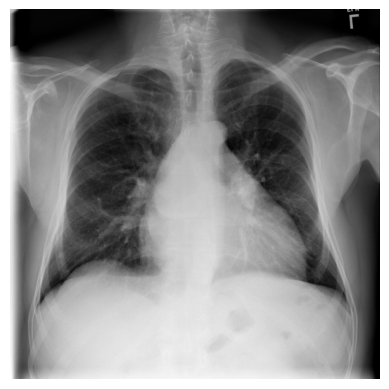

In [3]:
image_paths = glob.glob(os.path.join(DATA_DIR, 'images_*', 'images', '*.png'))
image_dict = {os.path.basename(path): path for path in image_paths}

sample_images = data['Image Index'].unique()
img_name = np.random.choice(sample_images, size=1, replace=False)[0]
img_path = image_dict.get(img_name)
img = Image.open(img_path)
data1 = data[data['Image Index'] == img_name]

# noinspection PyRedeclaration
img = torchvision.io.decode_image(image_dict.get("00000001_000.png"))
# print(img.shape)
img = img.permute(1,2,0)
plt.imshow(img, cmap = 'gray')
plt.axis('off')
# plt.show()

# Loading the model and dataloaders

In [4]:
# Getting the image paths
image_paths = glob.glob(os.path.join(DATA_DIR, 'images_*', 'images', '*.png'))

# Setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defining the model, loss function and optimizer
weights = models.ResNet50_Weights.DEFAULT # Pretrained weights
model = models.resnet50(weights=weights)
# Change the output layer to 14 classes
model.fc = nn.Linear(model.fc.in_features, out_features=out_features)

# Check if multiple GPUs are available
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model) # Use multiple GPUs if available
# Move the model to the device
model = model.to(device)

# Setting Optimizer by passing in the parameters
optimizer = optimizer(params=model.parameters(), lr=learning_rate)

# Try different transforms
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

#splitting the dataset
train_df, test_df = train_test_split(data, test_size=test_size)
train_df, validation_df = train_test_split(train_df, train_size=train_size, test_size=validation_size)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
validation_df.reset_index(drop=True, inplace=True)

# Creating the train dataloader
train_dataset = NIH_dataset(df=train_df, image_directories=image_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

# Creating the test dataloader
test_dataset = NIH_dataset(df=test_df, image_directories=image_paths, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

# Creating the validation dataloader
validation_dataset = NIH_dataset(df=validation_df, image_directories=image_paths, transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=train_batch_size, shuffle=True)

# Training the model

D:\College\Fall2024\4ZP6A-capstone\backend\.venv\Lib\site-packages\torchmetrics\utilities\prints.py:43: FutureWarning: The default value for `maximize` will be changed from `True` to `None` in v1.7.0 of TorchMetrics,will automatically infer the value based on the `higher_is_better` attribute of the metric (if such attribute exists) or raise an error if it does not. If you are explicitly setting the `maximize` argument to either `True` or `False` already, you can ignore this warning.
  warnings.warn(*args, **kwargs)  # noqa: B028


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/1 [00:00<?, ?it/s]

D:\College\Fall2024\4ZP6A-capstone\backend\.venv\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
D:\College\Fall2024\4ZP6A-capstone\backend\.venv\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


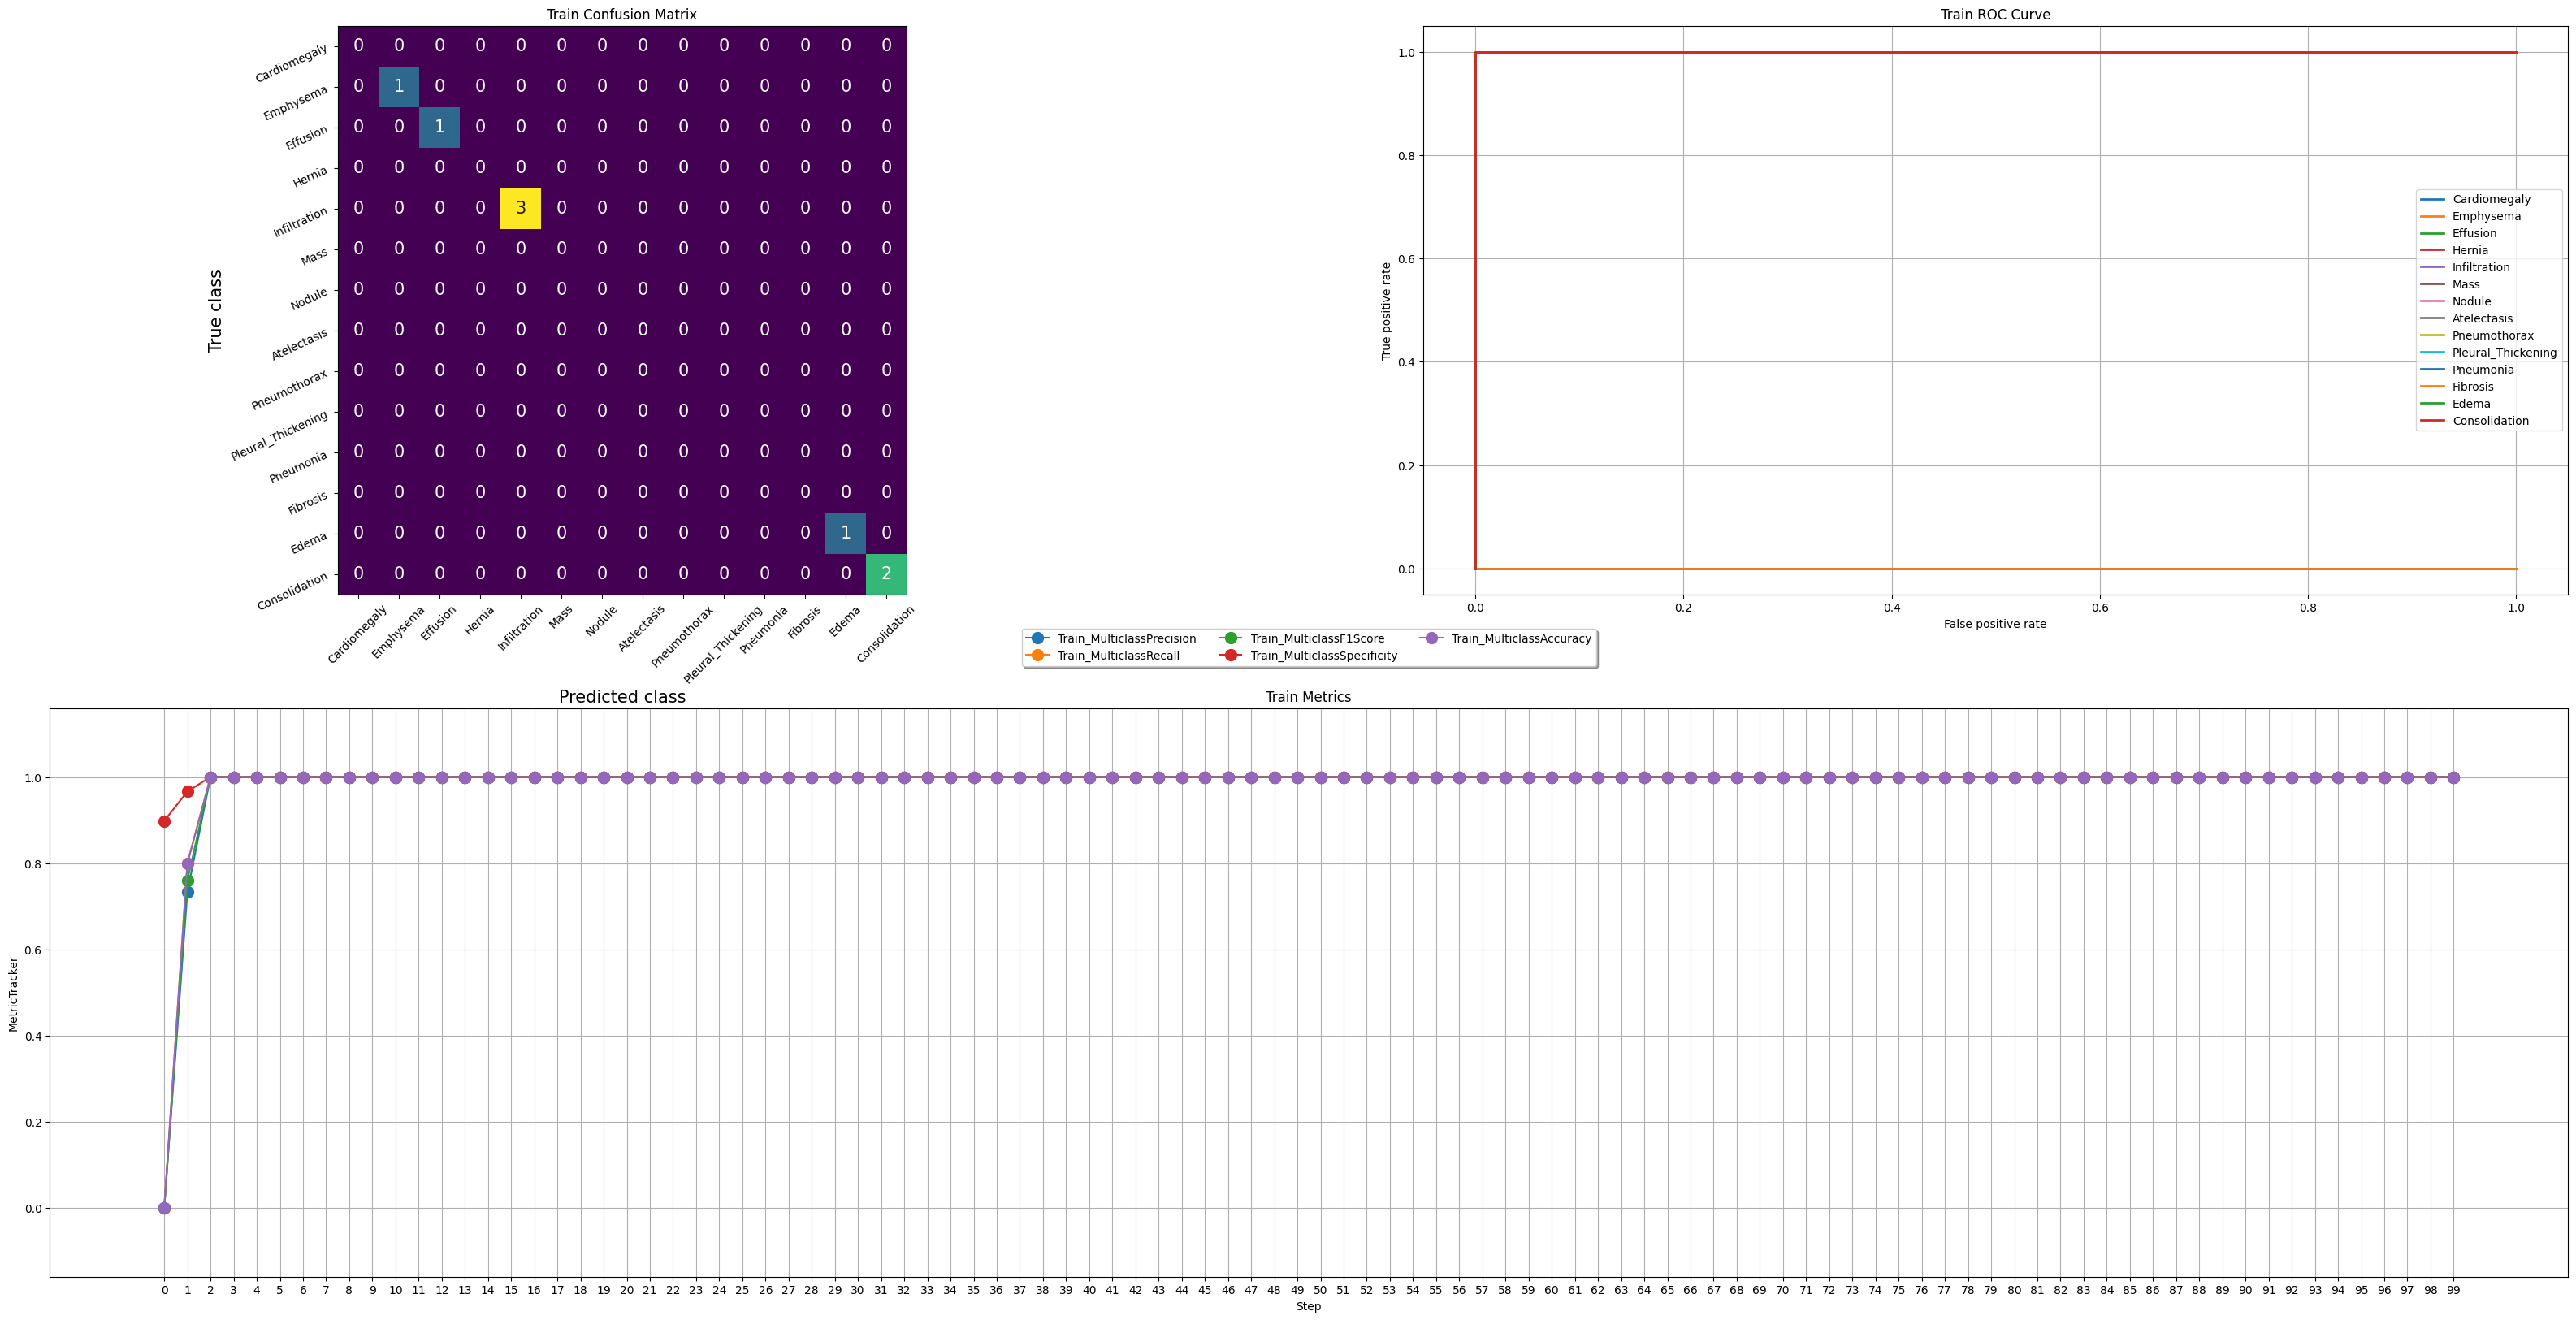

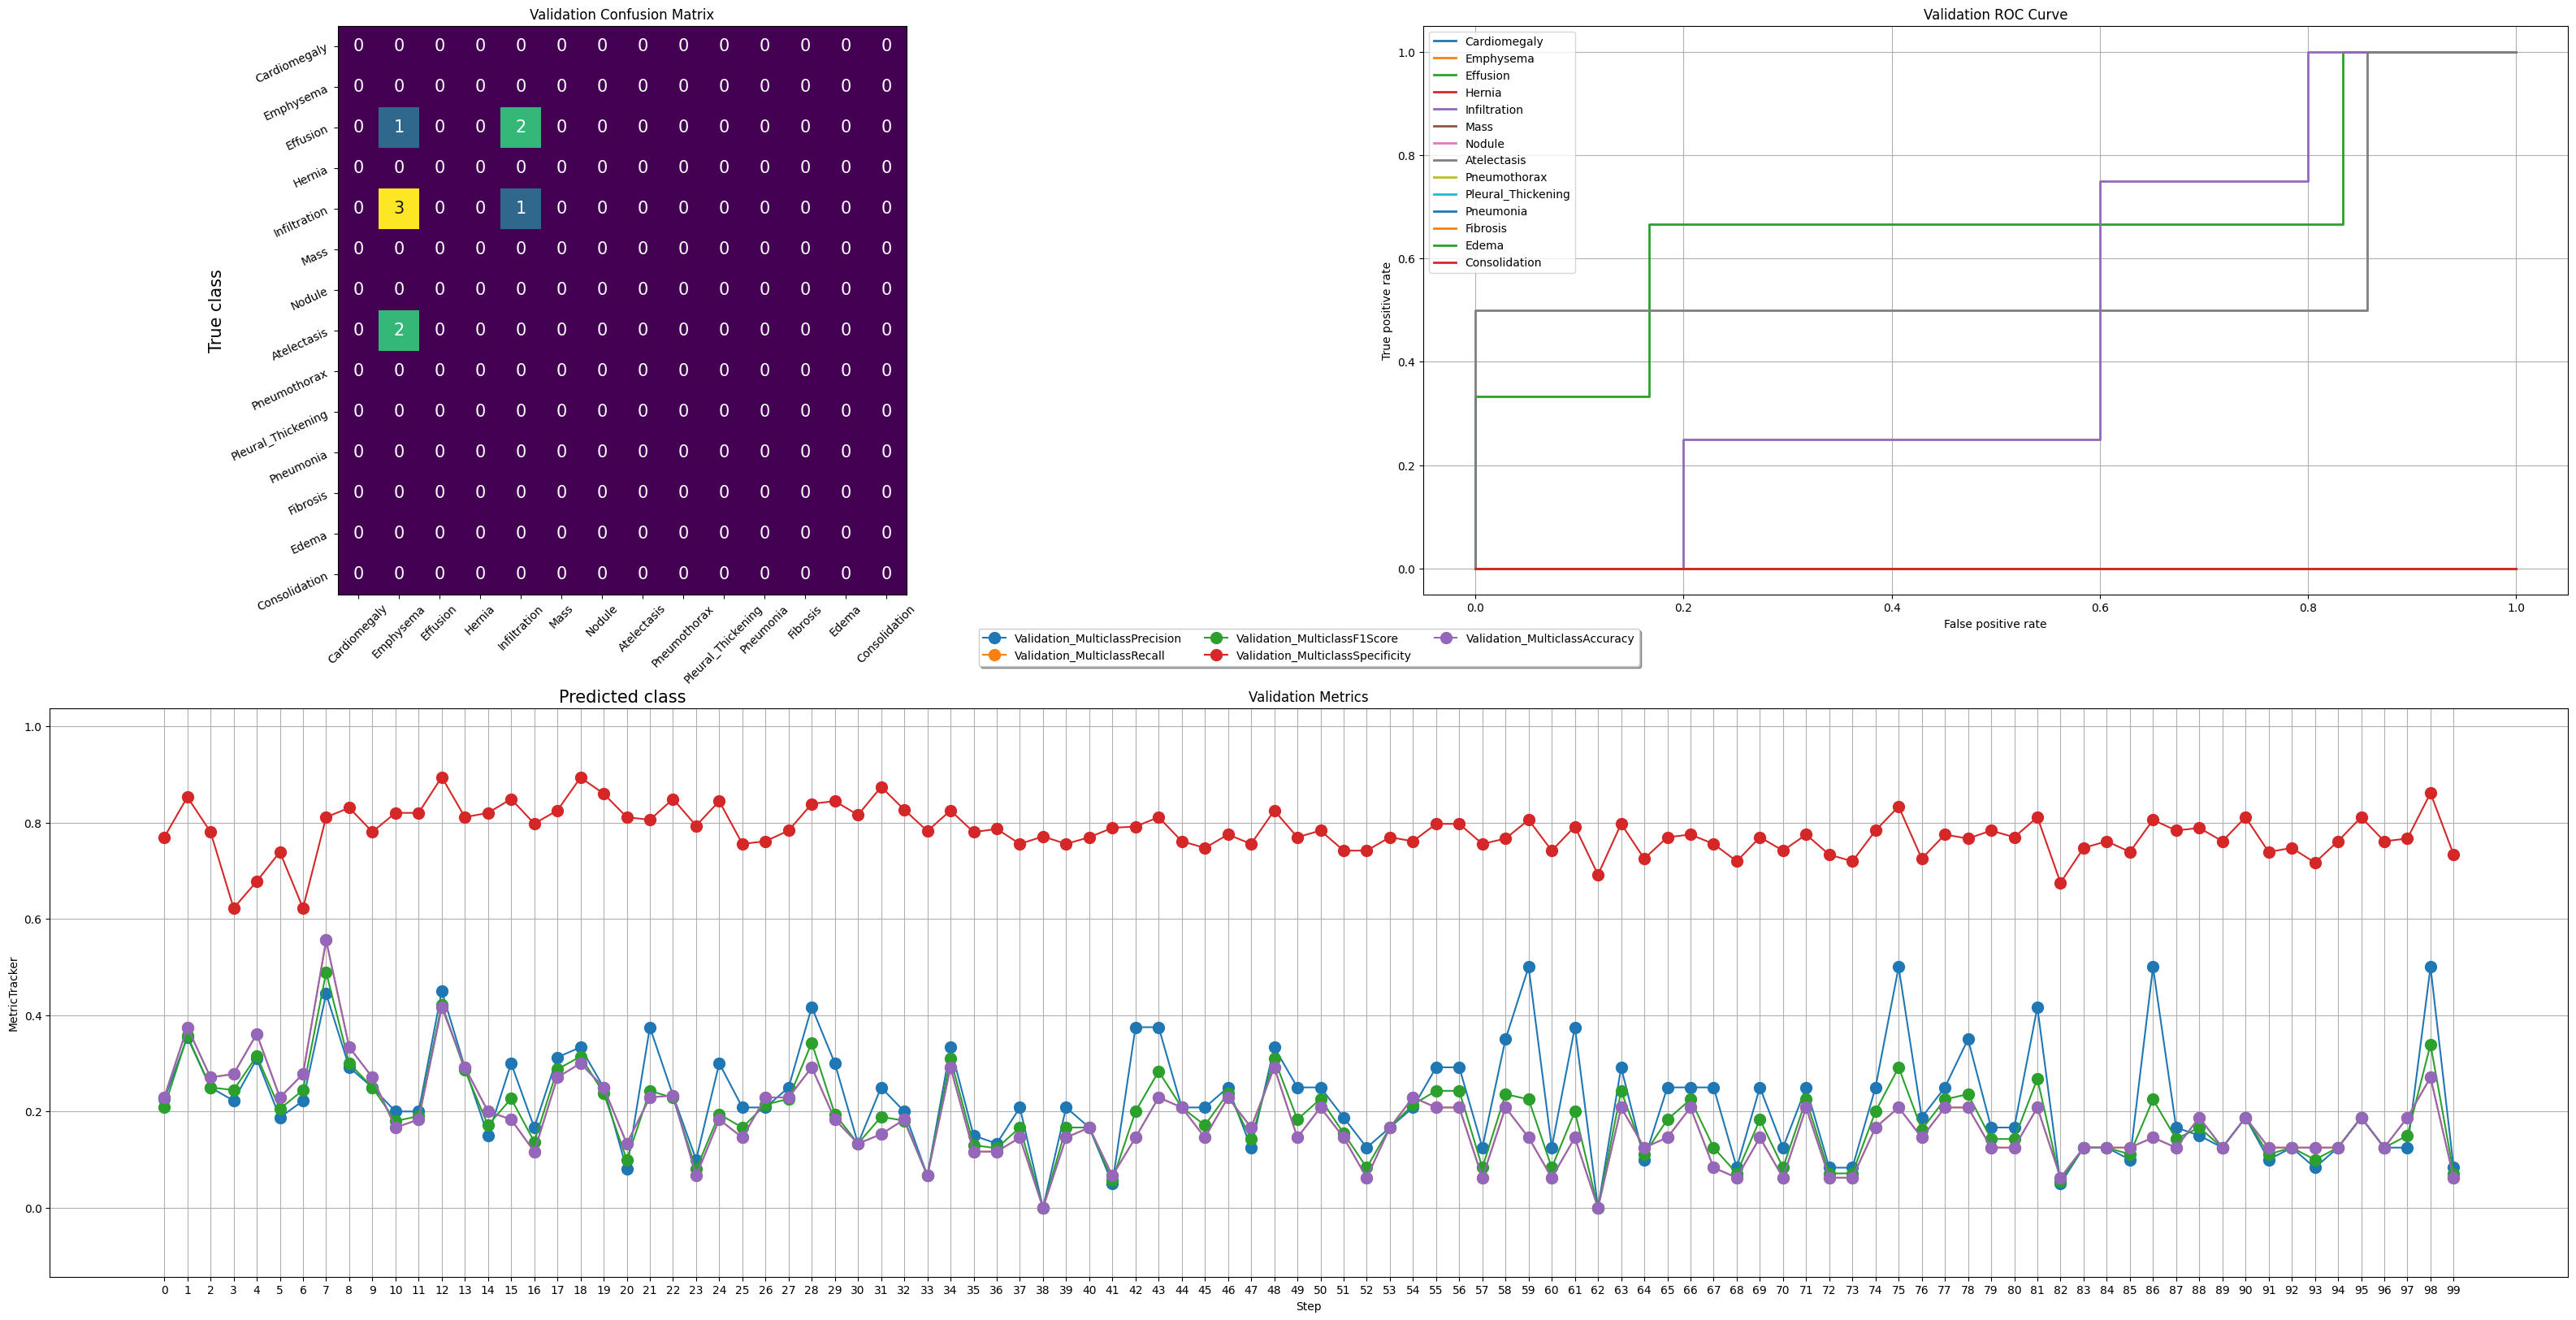

In [5]:
# noinspection PyShadowingNames
def train(epochs: int, model: nn.Module, train_dataloader: DataLoader, criterion: nn.Module, optimizer: torch.optim.Optimizer, validation_dataloader: DataLoader=None) -> tuple[metrics, MetricTracker] or tuple[metrics, MetricTracker, metrics, MetricTracker]:
    """
    Function to train the model and get the metrics for the training and validation dataloaders. Metrics are calculated for each batch and stored as average over the epoch.
    :param epochs: The number of epochs to train the model
    :param model: nn.Module: The model to train
    :param train_dataloader: pytorch DataLoader, the dataloader for the training data
    :param criterion: The loss function to use, must be able to take input as raw model output and target labels
    :param optimizer: Optimizer to use for updating the model weights
    :param validation_dataloader: DataLoader for the validation data, if None, only training metrics are returned
    :return: Returns either a tuple of train_metrics, train_tracker or a tuple of train_metrics, train_tracker, validation_metrics, validation_tracker
    """
    # Defining the metrics
    train_metrics = metrics.clone(prefix="Train_").to(device)
    validation_metrics = metrics.clone(prefix="Validation_").to(device)
    # Define the torchmetrics tracker
    train_tracker = torchmetrics.wrappers.MetricTracker(train_metrics)
    validation_tracker = torchmetrics.wrappers.MetricTracker(validation_metrics)

    # Loop through the epochs
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # Increment the epoch counter
        train_tracker.increment(), validation_tracker.increment()
        # Set the model to training mode
        model.train()

        # -------------- #
        # Training loop  #
        # -------------- #
        for inputs, labels in tqdm(train_dataloader, desc="Train Batches"):
        # for inputs, labels in train_dataloader:
            # Move input and label tensors to the device
            inputs = inputs.to(device)
            labels = torch.tensor([disease_to_number[label] for label in labels]).to(device)
            
            # Zero out the optimizer
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            # noinspection PyUnusedLocal
            max_logits, out_lab = torch.max(outputs, 1)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Update Metrics for this batch
            train_tracker.update(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

        # Check if only train dataloader is passed or validation dataloader is also passed
        if validation_dataloader is None:
            continue

        # ---------------- #
        # Validation loop  #
        # ---------------- #
        model.eval() # Set the model to evaluation mode
        with torch.no_grad():
            for inputs, labels in tqdm(validation_dataloader, desc="Validation Batches"):
                # Move input and label tensors to the device
                inputs = inputs.to(device)
                labels = torch.tensor([disease_to_number[label] for label in labels]).to(device)

                # Forward pass
                outputs = model(inputs)

                # Update Metrics for this batch
                validation_tracker.update(outputs, labels)

    # Return the metrics depending on the presence of validation dataloader
    if validation_dataloader is None:
        return train_metrics, train_tracker
    return train_metrics, train_tracker, validation_metrics, validation_tracker

# Train the model
train_metrics, train_tracker, validation_metrics, validation_tracker = train(epochs, model, train_loader, criterion, optimizer, validation_loader)
# Plot the metrics
metrics_plot(train_tracker, save=True)
metrics_plot(validation_tracker, save=True, title1="Validation")

# Save the model and dataloaders

In [6]:
# Save the model
torch.save(model, f"{model.__class__.__name__} epochs={epochs} lr={learning_rate} bsize={train_batch_size}.pth")

train_df.to_pickle('train_df.pkl')
test_df.to_pickle('test_df.pkl')

# Clearing cache and running garbage collector

In [7]:
# Empty GPU
import gc

try:
    del model
except:
    pass
try:
    del metrics
except:
    pass

gc.collect()
torch.cuda.empty_cache()
